In [1]:
import os
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys; sys.path.insert(0, "../utils/")
from data_utils import get_data_location, get_clinical_df, get_bluepoints_df, get_manual_severity_scores
from ml_pipeline import ModelEvaluation, highlight_max

DATA_PATH = get_data_location()

In [2]:
DIAGRAMS_PATH = os.path.join(DATA_PATH,"cropped_videos_segmented/cubicial_persistence")

# List all files & directories
diagrams_files = os.listdir(DIAGRAMS_PATH)

# keep only files that end with .npy
diagrams_files = [x for x in diagrams_files if x.endswith(".pickle")]

len(diagrams_files)

369

In [3]:
# Load the first file
diagrams = pd.read_pickle(os.path.join(DIAGRAMS_PATH, diagrams_files[0]))

# Squeeze all diagrams in the dict to remove the first dimension
diagrams_squeezed = {k: v.squeeze() for k, v in diagrams.items()}

from gtda.plotting import plot_diagram
#plot_diagram(diagrams_squeezed[3])

In [ ]:
import pandas as pd

# Create a dataframe from digrams_files
df = pd.DataFrame(diagrams_files, columns=["file_name"])
# Split the file name to get the patient id
df["Patient ID"] = df["file_name"].apply(lambda x: x.split("_")[2])
# Split the file name to get the video name
df["video_name"] = df["file_name"].apply(lambda x: x.split("_")[3] + "_" + x.split("_")[4])
# Load the diagrams into the dataframe
df["diagrams"] = df["file_name"].apply(lambda x: pd.read_pickle(os.path.join(DIAGRAMS_PATH, x)))

df.head()

In [ ]:
clinical_data = get_clinical_df()

clinical_data = clinical_data[["Video ID", "clin_diagn#COVID19_pneumonia"]]
clinical_data.columns = ["Patient ID", "COVID19"]
df = pd.merge(df, clinical_data, on="Patient ID", how="left")
bp = get_bluepoints_df()
df = pd.merge(df, bp[["Bluepoint", "video_name"]], on="video_name", how="left")

df.head(1)

In [6]:
def featurize_diagrams(diagrams, representation):
    """Featurize diagrams with a given representation.
    
    Parameters
    ----------
    diagrams : dict
        A dict of diagrams, where the keys are the homology dimensions and the values are the diagrams.
    representation : object
        A representation object from gtda.diagrams.
        
    Returns
    -------
    X : ndarray
        A feature matrix.
    """
    # Iterate through dict and featureize each diagram
    for dim, diagram in diagrams.items():
        try:
            X_dim = representation.fit_transform(diagram)
        except:
            print(f"Failed to get {representation} for class {dim}")
            continue
        # For first diagram representation, initialize X
        if dim == 1:
            X = X_dim
        else:
            # Stack the feature matrices
            X = np.vstack((X, X_dim))
    X = X.flatten()
    return X


In [ ]:
# Import different featurizers
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import Amplitude
from gtda.diagrams import BettiCurve
from gtda.diagrams import PersistenceImage
from gtda.diagrams import NumberOfPoints

# Store all featurizer in a dict with name as key
featurizers = {"Persistence Entropy" : PersistenceEntropy(),
                "Number of Points" : NumberOfPoints(),
                "Wasserstein Amplitude" : Amplitude(metric='wasserstein'),
                "Bottleneck Amplitude" : Amplitude(metric='bottleneck'),
                "Landscape Amplitude" : Amplitude(metric='landscape'),
                "Betti Curves" : BettiCurve(n_bins=10),
                "Persistence Image" : PersistenceImage(n_bins=5)
                }
# Filter out 4 samples because the cause Persistence Image to crash:
df = df.drop([29, 39, 352, 368]).reset_index(drop=True)

# Apply the different featurizers to the diagrams and add them to the dataframe in separate columns
for name, featurizer in featurizers.items():
    print(f"Calculating {name}")
    df[name] = df["diagrams"].apply(lambda x: featurize_diagrams(x, featurizer))
df.head(1)

## Train models on features

In [8]:
Classifier = ModelEvaluation("classification")

In [29]:
featurizer_models = pd.DataFrame()
featurizer_models_all = pd.DataFrame()
featurizer_models_std = pd.DataFrame()
for name, featurizer in featurizers.items():
    print(f"Training model for {name}...")
    X = np.stack(df[name].values)
    y = df["COVID19"].values
    groups = df["Patient ID"].values
    
    scores, scores_mean, scores_std = Classifier.train_models(X, y, groups=groups, plot=False, return_std = True)
    scores = pd.concat([scores], keys=[name], names=['Featurizer'])
    scores_mean = pd.concat([scores_mean], keys=[name], names=['Featurizer'])
    scores_std = pd.concat([scores_std], keys=[name], names=['Featurizer'])
    
    featurizer_models_all = pd.concat([featurizer_models_all, scores])
    featurizer_models = pd.concat([featurizer_models, scores_mean])
    featurizer_models_std = pd.concat([featurizer_models_std, scores_std])
    
featurizer_models.groupby("Featurizer").mean().sort_values(by=["test_accuracy", "test_f1"], ascending=False).style.apply(highlight_max).format("{:.2f}")

Training model for Persistence Entropy...
Training model for Number of Points...
Training model for Wasserstein Amplitude...
Training model for Bottleneck Amplitude...
Training model for Landscape Amplitude...
Training model for Betti Curves...
Training model for Persistence Image...


/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

,test_accuracy,test_sensitivity,test_specificity,test_f1
Featurizer,,,,
Number of Points,0.67,0.73,0.59,0.68
Wasserstein Amplitude,0.63,0.68,0.59,0.64
Betti Curves,0.63,0.68,0.56,0.64
Persistence Entropy,0.63,0.68,0.60,0.64
Persistence Image,0.62,0.63,0.58,0.61
Bottleneck Amplitude,0.61,0.68,0.57,0.63
Landscape Amplitude,0.60,0.68,0.56,0.63


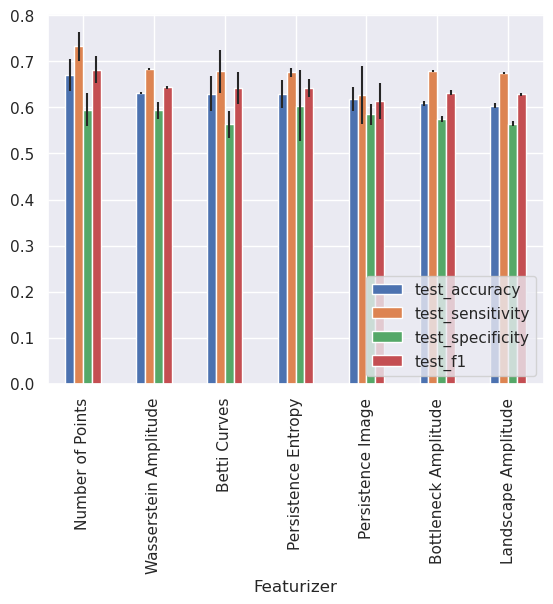

In [30]:
featurizer_models.groupby("Featurizer").mean().sort_values(by=["test_accuracy", "test_f1"], ascending=False).plot.bar(yerr=featurizer_models.groupby("Featurizer").std())
plt.legend(loc='lower right')

,test_accuracy,test_sensitivity,test_specificity,test_f1
Number of Points (LR),0.70,0.76,0.62,0.71
Betti Curves (RF),0.67,0.73,0.60,0.68
Persistence Entropy (LR),0.66,0.69,0.66,0.66
Persistence Image (RF),0.65,0.70,0.60,0.66
Wasserstein Amplitude (LR),0.63,0.68,0.60,0.65
Bottleneck Amplitude (LR),0.61,0.68,0.58,0.64
Landscape Amplitude (RF),0.61,0.68,0.57,0.63


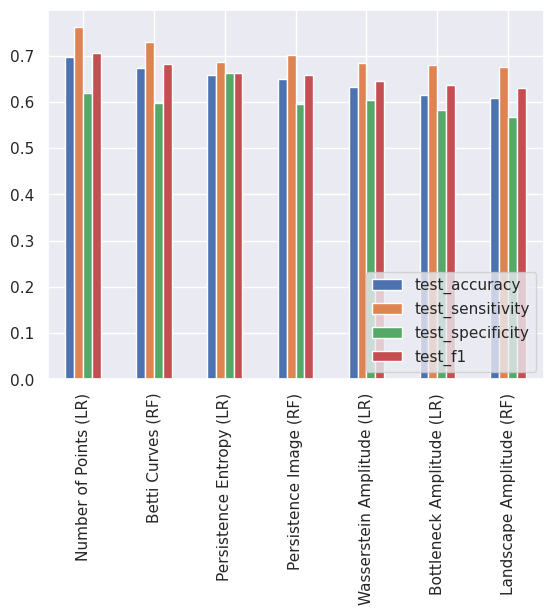

In [31]:
grouped = featurizer_models.groupby("Featurizer")
max_index = grouped["test_accuracy"].idxmax()
best_models = featurizer_models.loc[max_index].sort_values("test_accuracy", ascending=False)
best_models.index = best_models.reset_index().Featurizer + " (" + best_models.reset_index().model + ")"

best_models_std = featurizer_models_std.loc[max_index]
best_models_std.index = best_models_std.reset_index().Featurizer + " (" + best_models_std.reset_index().model + ")"
best_models_std = best_models_std.loc[best_models.index]

best_models.plot.bar()
plt.legend(loc='lower right')

best_models.style.apply(highlight_max).format("{:.2f}")

In [32]:
# Make latex
latex = best_models.applymap(lambda x: f"{x:.2f}") + " $_{\pm " + best_models_std.applymap(lambda x: f"{x:.2f}") + "}$"
# Drop all rows containint "Amplitude"
latex = latex[~latex.index.str.contains("Amplitude")]
print(latex.to_latex(escape=False))

\begin{tabular}{lllll}
\toprule
{} &       test_accuracy &    test_sensitivity &    test_specificity &             test_f1 \\
\midrule
Number of Points (LR)    &  0.70 $_{\pm 0.05}$ &  0.76 $_{\pm 0.08}$ &  0.62 $_{\pm 0.06}$ &  0.71 $_{\pm 0.15}$ \\
Betti Curves (RF)        &  0.67 $_{\pm 0.04}$ &  0.73 $_{\pm 0.09}$ &  0.60 $_{\pm 0.10}$ &  0.68 $_{\pm 0.14}$ \\
Persistence Entropy (LR) &  0.66 $_{\pm 0.06}$ &  0.69 $_{\pm 0.12}$ &  0.66 $_{\pm 0.06}$ &  0.66 $_{\pm 0.12}$ \\
Persistence Image (RF)   &  0.65 $_{\pm 0.06}$ &  0.70 $_{\pm 0.09}$ &  0.60 $_{\pm 0.11}$ &  0.66 $_{\pm 0.15}$ \\
\bottomrule
\end{tabular}



# Number of Points correlated with class volume
NoP performs the best.  
-> Correlate Number of Points with Segmentation Volume.  
-> Does it basically represent Volume? Does it perform better or worse or the same as simple volume?

In [33]:
DATA_PATH = get_data_location()
pixel_count_path = os.path.join(DATA_PATH,"cropped_videos_segmented/post_processing")

# List all files & directories
files = os.listdir(pixel_count_path)

# keep only .csv files
csvs = [x for x in files if x.endswith(".gif_pixel_counts.csv")]

# Read all csvs into one dataframe
df_pixel = pd.concat((pd.read_csv(os.path.join(pixel_count_path, f)) for f in csvs))

# Define class names
class_names = {"blue":"a-lines", "green":"few_b-lines", "orange":"more_b-lines", "red":"white_lung", "black":"nothing"}

# Rename columns blue, green, orange, red, black to class names
df_pixel = df_pixel.rename(columns=class_names)

# Sum pixel counts for video
df_pixel = df_pixel.groupby("video_name").sum().drop(columns=["Frame","nothing"])
# merge with df
df_pixel = pd.merge(df, df_pixel, on="video_name")

In [34]:
features = ["a-lines", "few_b-lines", "more_b-lines", "white_lung"]
dimensions = ["0", "1", "2"]

idx = 0
for f in features:
    for d in dimensions:
        df_pixel[f"NoP_{f}_{d}"] = df_pixel["Number of Points"].apply(lambda x: x[idx])
        corr = df_pixel[f].corr(df_pixel[f"NoP_{f}_{d}"])
        print(f"Correlation for {f} dim:{d}: {corr:.2f}")
        idx += 1

Correlation for a-lines dim:0: 0.97
Correlation for a-lines dim:1: 0.98
Correlation for a-lines dim:2: 0.98
Correlation for few_b-lines dim:0: 0.87
Correlation for few_b-lines dim:1: 0.96
Correlation for few_b-lines dim:2: 0.93
Correlation for more_b-lines dim:0: 0.92
Correlation for more_b-lines dim:1: 0.95
Correlation for more_b-lines dim:2: 0.94
Correlation for white_lung dim:0: 0.95
Correlation for white_lung dim:1: 0.97
Correlation for white_lung dim:2: 0.96


Not very suprisingly: Number of points in the persistence diagram are highly correlated with the pixel count. So it seems more likely that the best performing predictor is not picking up on some internal geometry in the data but simply mirroring the well-performing pixel count.

# Patient Level

In [ ]:
# Aggregate feature vectors across each Patient using the mean
patient_level_df = df.groupby("Patient ID")[list(featurizers.keys())].mean().reset_index()
# Add back Covid variable
patient_level_df = pd.merge(df.groupby("Patient ID")["COVID19"].first().reset_index(), patient_level_df)
patient_level_df.head(1)

In [36]:
featurizer_models_patients = pd.DataFrame()
featurizer_models_all_patients = pd.DataFrame()
featurizer_models_std_patients = pd.DataFrame()
for name, featurizer in featurizers.items():
    print(f"Training model for {name}...")
    X = np.stack(patient_level_df[name].values)
    y = patient_level_df["COVID19"].values
    
    scores, scores_mean, scores_std = Classifier.train_models(X, y, plot=False, return_std = True)
    scores = pd.concat([scores], keys=[name], names=['Featurizer'])
    scores_mean = pd.concat([scores_mean], keys=[name], names=['Featurizer'])
    scores_std = pd.concat([scores_std], keys=[name], names=['Featurizer'])
    
    featurizer_models_all_patients = pd.concat([featurizer_models_all_patients, scores])
    featurizer_models_patients = pd.concat([featurizer_models_patients, scores_mean])
    featurizer_models_std_patients = pd.concat([featurizer_models_std_patients, scores_std])
    
#featurizer_models.style.apply(highlight_max).format("{:.2f}")

Training model for Persistence Entropy...
Training model for Number of Points...
Training model for Wasserstein Amplitude...
Training model for Bottleneck Amplitude...
Training model for Landscape Amplitude...
Training model for Betti Curves...
Training model for Persistence Image...


,test_accuracy,test_sensitivity,test_specificity,test_f1
Persistence Entropy (RF),0.76,0.79,0.73,0.77
Number of Points (LR),0.76,0.81,0.70,0.78
Wasserstein Amplitude (SVM),0.75,0.76,0.73,0.76
Betti Curves (LR),0.75,0.79,0.70,0.77
Landscape Amplitude (SVM),0.73,0.75,0.70,0.74
Bottleneck Amplitude (SVM),0.72,0.76,0.67,0.74
Persistence Image (RF),0.72,0.73,0.70,0.72


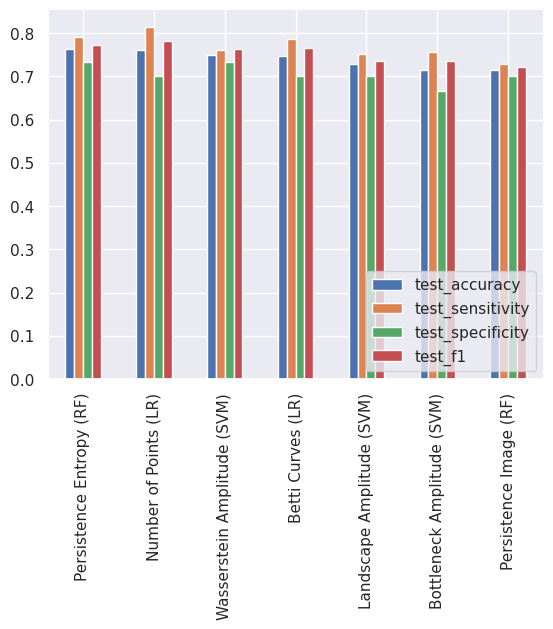

In [37]:
grouped = featurizer_models_patients.groupby("Featurizer")
max_index = grouped["test_accuracy"].idxmax()
best_models = featurizer_models_patients.loc[max_index].sort_values("test_accuracy", ascending=False)
best_models.index = best_models.reset_index().Featurizer + " (" + best_models.reset_index().model + ")"

best_models_std = featurizer_models_std_patients.loc[max_index]
best_models_std.index = best_models_std.reset_index().Featurizer + " (" + best_models_std.reset_index().model + ")"
best_models_std = best_models_std.loc[best_models.index]

best_models.plot.bar()
plt.legend(loc='lower right')

best_models.style.apply(highlight_max).format("{:.2f}")

In [38]:
# Make latex
latex = best_models.applymap(lambda x: f"{x:.2f}") + " $_{\pm " + best_models_std.applymap(lambda x: f"{x:.2f}") + "}$"
# Drop all rows containint "Amplitude"
latex = latex[~latex.index.str.contains("Amplitude")]
print(latex.to_latex(escape=False))

\begin{tabular}{lllll}
\toprule
{} &       test_accuracy &    test_sensitivity &    test_specificity &             test_f1 \\
\midrule
Persistence Entropy (RF) &  0.76 $_{\pm 0.12}$ &  0.79 $_{\pm 0.16}$ &  0.73 $_{\pm 0.09}$ &  0.77 $_{\pm 0.12}$ \\
Number of Points (LR)    &  0.76 $_{\pm 0.08}$ &  0.81 $_{\pm 0.08}$ &  0.70 $_{\pm 0.14}$ &  0.78 $_{\pm 0.08}$ \\
Betti Curves (LR)        &  0.75 $_{\pm 0.06}$ &  0.79 $_{\pm 0.09}$ &  0.70 $_{\pm 0.18}$ &  0.77 $_{\pm 0.04}$ \\
Persistence Image (RF)   &  0.72 $_{\pm 0.11}$ &  0.73 $_{\pm 0.19}$ &  0.70 $_{\pm 0.14}$ &  0.72 $_{\pm 0.13}$ \\
\bottomrule
\end{tabular}



## Severity Scores

In [19]:
sev_scores = get_manual_severity_scores()
sev_scores = sev_scores[["Severity Score", "video_name"]]
sev_scores["Severity Score"] = sev_scores["Severity Score"].astype(int)
df = pd.merge(df, sev_scores, on="video_name")

Number of discarded rows: 8


/tmp/ipykernel_18698/1783145124.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sev_scores["Severity Score"] = sev_scores["Severity Score"].astype(int)


In [20]:
import importlib
import ml_pipeline
importlib.reload(ml_pipeline)
from ml_pipeline import ModelEvaluation


Multi_Classifier = ModelEvaluation(mode="classification_multi_label")

In [21]:
featurizer_models = pd.DataFrame()
featurizer_models_all = pd.DataFrame()
featurizer_models_std = pd.DataFrame()
for name, featurizer in featurizers.items():
    print(f"Training model for {name}...")
    X = np.stack(df[name].values)
    y = df["Severity Score"].values
    groups = df["Patient ID"].values
    
    scores, scores_mean, scores_std = Multi_Classifier.train_models(X, y, groups=groups, plot=False, return_std = True)
    scores = pd.concat([scores], keys=[name], names=['Featurizer'])
    scores_mean = pd.concat([scores_mean], keys=[name], names=['Featurizer'])
    scores_std = pd.concat([scores_std], keys=[name], names=['Featurizer'])
    
    featurizer_models_all = pd.concat([featurizer_models_all, scores])
    featurizer_models = pd.concat([featurizer_models, scores_mean])
    featurizer_models_std = pd.concat([featurizer_models_std, scores_std])

featurizer_models.groupby("Featurizer").mean().sort_values(by=["test_f1"], ascending=False).style.apply(highlight_max).format("{:.2f}")

Training model for Persistence Entropy...
Training model for Number of Points...


/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model for Wasserstein Amplitude...
Training model for Bottleneck Amplitude...
Training model for Landscape Amplitude...


/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model for Betti Curves...


/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Training model for Persistence Image...


/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

,test_accuracy,test_f1,test_recall,test_precision
Featurizer,,,,
Persistence Entropy,0.36,0.34,0.36,0.37
Wasserstein Amplitude,0.35,0.34,0.35,0.38
Persistence Image,0.34,0.33,0.34,0.38
Bottleneck Amplitude,0.34,0.33,0.34,0.37
Betti Curves,0.33,0.32,0.33,0.36
Landscape Amplitude,0.32,0.31,0.32,0.33
Number of Points,0.34,0.31,0.34,0.34


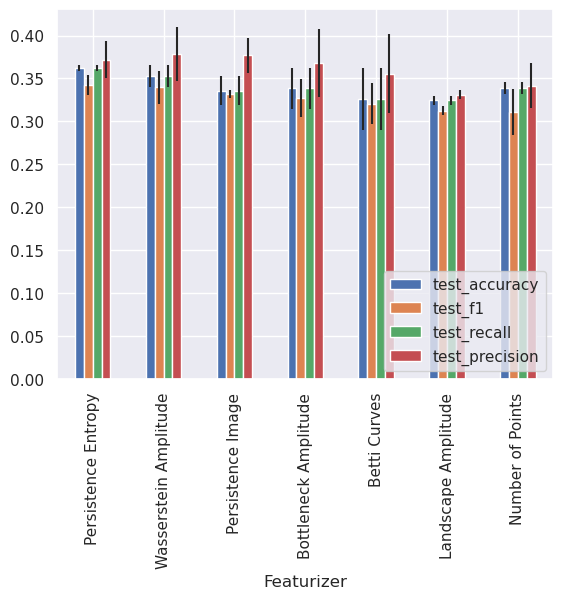

In [22]:
featurizer_models.groupby("Featurizer").mean().sort_values(by=["test_f1"], ascending=False).plot.bar(yerr=featurizer_models.groupby("Featurizer").std())
plt.legend(loc='lower right')

,test_accuracy,test_f1,test_recall,test_precision
Wasserstein Amplitude (RF),0.37,0.36,0.37,0.41
Bottleneck Amplitude (RF),0.36,0.35,0.36,0.40
Betti Curves (RF),0.37,0.35,0.37,0.41
Number of Points (RF),0.35,0.34,0.35,0.37
Persistence Entropy (LR),0.37,0.34,0.37,0.36
Persistence Image (RF),0.35,0.34,0.35,0.40
Landscape Amplitude (SVM),0.33,0.31,0.33,0.33


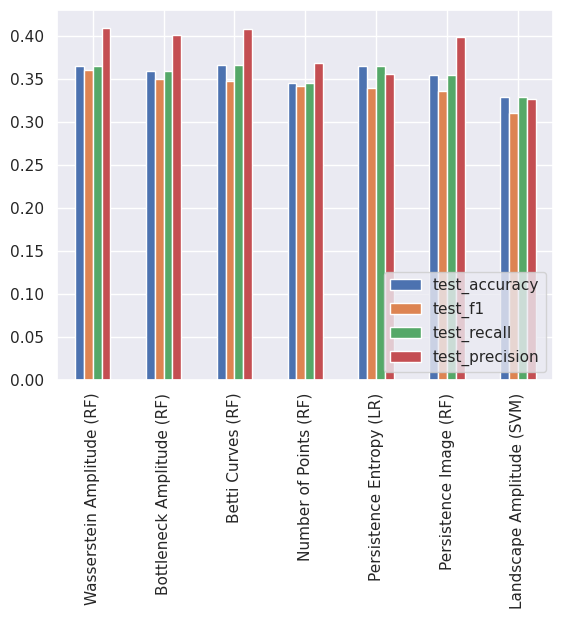

In [26]:
grouped = featurizer_models.groupby("Featurizer")
max_index = grouped["test_accuracy"].idxmax()
best_models = featurizer_models.loc[max_index].sort_values("test_f1", ascending=False)
best_models.index = best_models.reset_index().Featurizer + " (" + best_models.reset_index().model + ")"

best_models_std = featurizer_models_std.loc[max_index]
best_models_std.index = best_models_std.reset_index().Featurizer + " (" + best_models_std.reset_index().model + ")"
best_models_std = best_models_std.loc[best_models.index]

best_models.plot.bar()
plt.legend(loc='lower right')

best_models.style.apply(highlight_max).format("{:.2f}")

In [27]:
# Make latex
latex = best_models.applymap(lambda x: f"{x:.2f}") + " $_{\pm " + best_models_std.applymap(lambda x: f"{x:.2f}") + "}$"
# Drop accuracy
latex = latex.drop("test_accuracy", axis=1)
# Drop all rows containing "Amplitude"
latex = latex[~latex.index.str.contains("Amplitude")]
print(latex.to_latex(escape=False))

\begin{tabular}{llll}
\toprule
{} &             test_f1 &         test_recall &      test_precision \\
\midrule
Betti Curves (RF)        &  0.35 $_{\pm 0.06}$ &  0.37 $_{\pm 0.04}$ &  0.41 $_{\pm 0.10}$ \\
Number of Points (RF)    &  0.34 $_{\pm 0.09}$ &  0.35 $_{\pm 0.07}$ &  0.37 $_{\pm 0.10}$ \\
Persistence Entropy (LR) &  0.34 $_{\pm 0.05}$ &  0.37 $_{\pm 0.02}$ &  0.36 $_{\pm 0.08}$ \\
Persistence Image (RF)   &  0.34 $_{\pm 0.04}$ &  0.35 $_{\pm 0.02}$ &  0.40 $_{\pm 0.07}$ \\
\bottomrule
\end{tabular}

